In [10]:
import theano
import theano.tensor as T
import collections 
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

floatX = theano.config.floatX

# Data Generation

In [11]:
def mackey_glass(sample_len=2000, tau=17, seed=None, n_samples = 1):
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    delta_t = 10
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples

# Splitting and plotting data

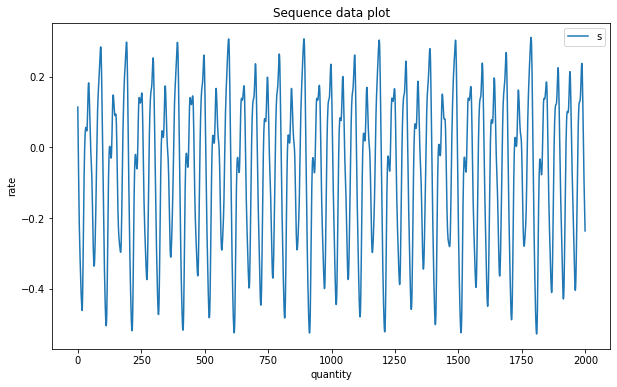

In [12]:
mackey_glass = mackey_glass(sample_len=2000, tau=17, seed=None, n_samples = 1)
data = np.asarray(mackey_glass[0], dtype=theano.config.floatX)

# Plotting the data
plt.figure(figsize=(10,6))
plt.plot(data)
plt.title('Sequence data plot')
plt.xlabel('quantity')
plt.ylabel('rate')
plt.legend('s')
plt.show()

# Splitting train and test data 
data_train = data[:1500]
data_val = data[1500:]

# GRU network class 

In [13]:
class GRU_network(object):
    def __init__(self, input_dim, recurrent_dim):
        
        self.input_dim = input_dim
        self.recurrent_dim = recurrent_dim
        
        # Initialize
        w_xh = np.random.normal(0, .01,(input_dim, recurrent_dim))
        w_hh = np.random.normal(0, .02, (recurrent_dim, recurrent_dim))
        
        w_xr = np.random.normal(0, .01,(input_dim, recurrent_dim))
        w_hr = np.random.normal(0, .02, (recurrent_dim, recurrent_dim))
        
        w_xz = np.random.normal(0, .01,(input_dim, recurrent_dim))
        w_hz = np.random.normal(0, .02, (recurrent_dim, recurrent_dim))
        
        
        # Create shared variables 
        self.w_xh = theano.shared(np.asarray(w_xh, dtype=floatX), name="w_xh")
        self.w_hh = theano.shared(np.asarray(w_hh, dtype=floatX), name="w_hh")
        self.b_h = theano.shared(np.zeros((recurrent_dim,), dtype=floatX), name="b_h")
        
        self.w_xr = theano.shared(np.asarray(w_xh, dtype=floatX), name="w_xr")
        self.w_hr = theano.shared(np.asarray(w_hh, dtype=floatX), name="w_hr")
        self.b_r = theano.shared(np.zeros((recurrent_dim,), dtype=floatX), name="b_r")
        
        self.w_xz = theano.shared(np.asarray(w_xh, dtype=floatX), name="w_xz")
        self.w_hz = theano.shared(np.asarray(w_hh, dtype=floatX), name="w_hz")
        self.b_z = theano.shared(np.zeros((recurrent_dim,), dtype=floatX), name="b_z")
        
        self.h0  = theano.shared(np.zeros((recurrent_dim,), dtype=floatX), name="h0")
        
        
        self.parameters = [self.w_xh, self.w_hh, self.b_h, self.w_xr, self.w_hr, self.b_r,
                           self.w_xz, self.w_hz, self.b_z, self.h0]
        
    def _step(self, input_t, previous):
        r = T.nnet.sigmoid(input_t.dot(self.w_xr) + previous.dot(self.w_hr) + self.b_r)
        z = T.nnet.sigmoid(input_t.dot(self.w_xz) + previous.dot(self.w_hz) + self.b_z)
        hhat = T.tanh(input_t.dot(self.w_xh) + (r * previous).dot(self.w_hh) + self.b_h)
        h = (1 - z) * previous + z * hhat
        return h
    
    def __call__(self,x):
        #x_w_xh = T.dot(x, self.w_xh) + self.b_h TRY THIS ONE 
        result, updates = theano.scan(self._step,
                                     sequences=[x],
                                     outputs_info=[self.h0],
                                     n_steps=x.shape[0])
        
        return result
    

In [14]:
w_ho_np = np.random.normal(0, 0.01,(15,1))
w_ho = theano.shared(np.asarray(w_ho_np, dtype=floatX),name='w_ho')
b_o = theano.shared(np.zeros((1,),dtype=floatX),name='b_o')

In [15]:
x = T.matrix('x')
my_rnn = GRU_network(1, 15)
hidden = my_rnn(x)
prediction = T.dot(hidden, w_ho) + b_o
parameters = my_rnn.parameters + [w_ho, b_o]
l2 = sum((p**2).sum() for p in parameters)
mse = T.mean((prediction[:-1] - x[1:])**2)
cost = mse + 0.0001 * l2
gradient = T.grad(cost, wrt=parameters)

In [16]:
lr = .3
updates = [(par, par - lr * gra) for par, gra in zip(parameters, gradient)]
update_model = theano.function([x], cost, updates=updates)
get_cost = theano.function([x], mse)
predict = theano.function([x], prediction)
get_hidden = theano.function([x], hidden)
get_gradient = theano.function([x], gradient)

# Computing the cost/error function

In [17]:
for i in range(1001):
    mse_train = update_model(data_train)
    
    if i % 100 == 0:
        mse_val = get_cost(data_val)
        print('Epoch {}: train mse: {}   validation mse: {}'.format(i,mse_train,mse_val))

Epoch 0: train mse: 0.05073065302148342   validation mse: 0.047702804880077984
Epoch 100: train mse: 0.033947347453359165   validation mse: 0.03353441383950924
Epoch 200: train mse: 0.004404411624264918   validation mse: 0.004278676648835123
Epoch 300: train mse: 0.003977005979826147   validation mse: 0.0038315667928297196
Epoch 400: train mse: 0.0036547271956615325   validation mse: 0.0034921666790659134
Epoch 500: train mse: 0.0033993123449106953   validation mse: 0.0032206583553926523
Epoch 600: train mse: 0.003191068325898717   validation mse: 0.0029971646532500154
Epoch 700: train mse: 0.0030174504574226055   validation mse: 0.002809002281532925
Epoch 800: train mse: 0.0028700402765468188   validation mse: 0.0026476439560102084
Epoch 900: train mse: 0.0027429457316946113   validation mse: 0.0025071095799545427
Epoch 1000: train mse: 0.0026318958669651117   validation mse: 0.002383054554724088


# Performing Prediction

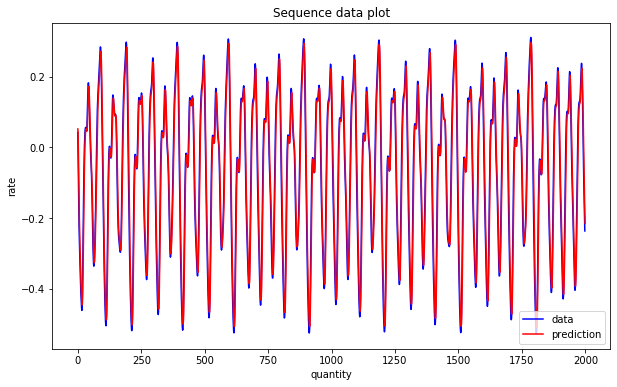

In [18]:
predict = theano.function([x], prediction)
prediction_np = predict(data)

plt.figure(figsize=(10,6))
plt.plot(data[1:], label='data', color='blue')
plt.plot(prediction_np, label='prediction', color='red')
plt.title('Sequence data plot')
plt.xlabel('quantity')
plt.ylabel('rate')
plt.legend(['Original data','Prediction'])
plt.legend()
plt.show()